In [1]:
# Loading packages

# Visualization and Analysis
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn
import datetime as date
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# SQLAlchemy and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_

# Building Engine, Automapping Base, Staring Session
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
session = Session(engine)
inspector = inspect(engine)

# Viewing classes from automap
# Base.classes.keys()

In [2]:
# Defining references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Printing table columns for reference
# f"measurement table columns"
# measurement_columns = inspector.get_columns('measurement')
# for m_c in measurement_columns:
#     print(m_c['name'], m_c["type"])
# f"---"
# f"station table columns"
# station_columns = inspector.get_columns('station')
# for s_c in station_columns:
#     print(s_c['name'], s_c["type"])

In [3]:
# Previewing table items
# engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()
# engine.execute('SELECT * FROM station LIMIT 10').fetchall()

# Exploratory Climate Analysis

In [4]:
# Notes: 
# - precipitation abbreviated as prcp and temperature 
# abbreviated as tobs like in measurement table
# -  .label() is the same as SQL select as aliasing

# Figuring out the latest date and the year prior in the dataset
latest_date_query = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
latest_date = latest_date_query[2:12]
f"The latest date in the dataset: {latest_date}"

year_before_latest_date_calc = str(int(latest_date[0:4]) - 1)
year_before_latest_date = year_before_latest_date_calc + latest_date[4:]
f"The year before the latest date in the dataset: {year_before_latest_date}"

# Retrieving last 12 months of prcp data
prcp_raw_points = session.query(Measurement.date.label('Date'),
                    Measurement.station.label('Station_ID'),
                    Measurement.prcp.label('Precipitation levels')).\
                    filter(Measurement.date.between(year_before_latest_date,latest_date)).\
                    order_by(Measurement.date)

prcp_df = pd.read_sql(prcp_raw_points.statement, prcp_raw_points.session.bind)

# Legacy code: Alternate way of making a dataframe using list comprehensions
# to unpack the output of tuples
# station_names = [prcp_raw_point[0] for prcp_raw_point in prcp_raw_points]
# prcp_points = [prcp_raw_point[1] for prcp_raw_point in prcp_raw_points]
# dates = [prcp_raw_point[2] for prcp_raw_point in prcp_raw_points]
# prcp_df = pd.DataFrame(
#     {'Date': dates,
#      'Station': station_names,
#      'Precipitation levels': prcp_points})

# Setting Date as the index
prcp_df.set_index('Date', inplace=True)

# Sorting by Date
prcp_df.sort_values(by='Date', ascending=True).head(10)
prcp_df.tail(10)

'The latest date in the dataset: 2017-08-23'

'The year before the latest date in the dataset: 2016-08-23'

,Station_ID,Precipitation levels
Date,,
2016-08-23,USC00519397,0.00
2016-08-23,USC00513117,0.15
2016-08-23,USC00514830,0.05
2016-08-23,USC00517948,NaN
2016-08-23,USC00519523,0.02
2016-08-23,USC00519281,1.79
2016-08-23,USC00516128,0.70
2016-08-24,USC00516128,1.45
2016-08-24,USC00519281,2.15


,Station_ID,Precipitation levels
Date,,
2017-08-21,USC00514830,0.02
2017-08-21,USC00519523,NaN
2017-08-21,USC00516128,0.56
2017-08-22,USC00519397,0.00
2017-08-22,USC00519523,0.00
2017-08-22,USC00516128,0.50
2017-08-23,USC00519397,0.00
2017-08-23,USC00514830,0.00
2017-08-23,USC00519523,0.08


<Figure size 1224x360 with 0 Axes>

Text(0, 0.5, 'Precipitation (inches)')

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Precipitation Levels 08/23/2016 - 08/23/2017')

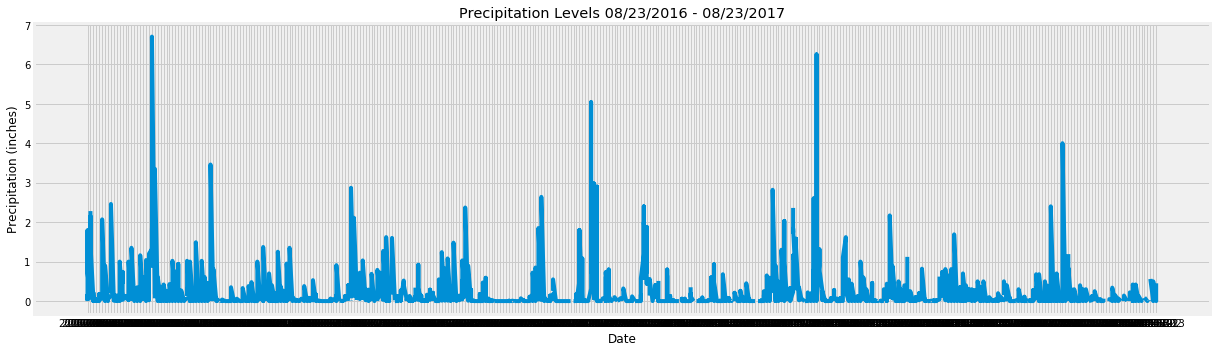

In [24]:
# Plotting figure of prcp_df
plt.figure(figsize=(17,5))
plt.plot(prcp_df.index, prcp_df['Precipitation levels'])
plt.ylabel("Precipitation (inches)")
plt.xlabel("Date")
plt.title("Precipitation Levels 08/23/2016 - 08/23/2017")
plt.tight_layout()
# Save an image of the chart and print to screen
plt.show()


# need help fixing the date values, is there a way to clean this up?

In [6]:
# prcp_df summary statistics
prcp_df.describe()

# Number of stations in dataset
HI_stations_count = session.query(Station).group_by(Station.station).count()
f"There are {HI_stations_count} weather stations in this dataset."

,Precipitation levels
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


'There are 9 weather stations in this dataset.'

In [7]:
# Listing stations in descending order of activity 
# in the whole dataset (via tobs count)
# Putting it into a dataframe for readability
StationActivity = session.query(Station.station.label('Station_ID'), 
                                Station.name.label('Station_Name'),
                func.count(Measurement.tobs).label('Activity_Count')).\
                filter(Station.station == Measurement.station).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc())
StationActivity_df = pd.read_sql(StationActivity.statement, StationActivity.session.bind)
StationActivity_df

f"The station with the most activity is Station ID: {StationActivity_df.at[0,'Station_ID']},"
f"at {StationActivity_df.at[0,'Station_Name']} with {StationActivity_df.at[0,'Activity_Count']} datapoints in the dataset."

,Station_ID,Station_Name,Activity_Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


'The station with the most activity is Station ID: USC00519281,'

'at WAIHEE 837.5, HI US with 2772 datapoints in the dataset.'

In [8]:
# Calculating the lowest temperature recorded, highest temperature recorded, 
# and average temperature from WAIHEE 837.5 in the whole dataset

Lowest_tobs_calc = session.query(func.min(Measurement.tobs)).\
            filter(Station.station == 'USC00519281').all()
Lowest_tobs_format = str(Lowest_tobs_calc[0])
Lowest_tobs = Lowest_tobs_format[1:3]
f"Lowest temperature recorded at Waihee: {Lowest_tobs} degrees"

Highest_tobs_calc = session.query(func.max(Measurement.tobs)).\
            filter(Station.station == 'USC00519281').all()
Highest_tobs_format = str(Highest_tobs_calc[0])
Highest_tobs = Highest_tobs_format[1:3]
f"Lowest temperature recorded at Waihee: {Highest_tobs} degrees"

Avg_tobs_calc = session.query(func.avg(Measurement.tobs)).\
            filter(Station.station == 'USC00519281').all()
Avg_tobs_format = str(Avg_tobs_calc[0])
Avg_tobs = Avg_tobs_format[1:3]
f"Average temperature recorded at Waihee: {Avg_tobs} degrees"

'Lowest temperature recorded at Waihee: 53 degrees'

'Lowest temperature recorded at Waihee: 87 degrees'

'Average temperature recorded at Waihee: 73 degrees'

In [9]:
# Retrieving last 12 months of tobs data from all stations
tobs_raw_points = session.query(Measurement.date.label('Date'),
                    Measurement.station.label('Station_ID'),
                    Measurement.tobs.label('Observed Temp')).\
                    filter(Measurement.date.between(year_before_latest_date,latest_date)).\
                    order_by(Measurement.date)

tobs_df = pd.read_sql(tobs_raw_points.statement, tobs_raw_points.session.bind)

# Setting Date as the index
tobs_df.set_index('Date', inplace=True)

# Sorting by Date
tobs_df.sort_values(by='Date', ascending=True).head(10)
# tobs_df.tail(10)

,Station_ID,Observed Temp
Date,,
2016-08-23,USC00519397,81.0
2016-08-23,USC00513117,76.0
2016-08-23,USC00514830,80.0
2016-08-23,USC00517948,80.0
2016-08-23,USC00519523,80.0
2016-08-23,USC00519281,77.0
2016-08-23,USC00516128,74.0
2016-08-24,USC00516128,74.0
2016-08-24,USC00519281,77.0


In [10]:
# Retrieving last 12 months of tobs data from Waihee
Waihee_raw_points = session.query(Measurement.date.label('Date'),
                    Measurement.tobs.label('Observed Temp')).\
                    filter(Measurement.date.between(year_before_latest_date,latest_date)).\
                    filter(Measurement.station == 'USC00519281').\
                    order_by(Measurement.date)

# Making a dataframe and finding its shape to confirm there
# is around a year's worth of data
Waihee_df = pd.read_sql(Waihee_raw_points.statement, Waihee_raw_points.session.bind)
Waihee_df.shape 
Waihee_df.head(5)
# Waihee_df.tail(5)

(352, 2)

,Date,Observed Temp
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 53., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

Text(0, 0.5, 'Frequency')

Text(0.5, 0, 'Observed Temperature')

Text(0.5, 1.0, 'Observed Temperatures at Waihee 08/23/2016 - 08/23/2017')

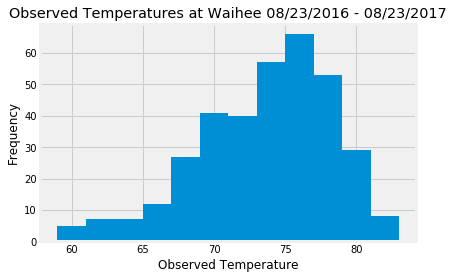

In [11]:
# Plotting a histogram for the last 12 months of tobs data from WAIHEE 837.5
tobs = [x[1] for x in Waihee_raw_points]
plt.hist(tobs, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Observed Temperature")
plt.title("Observed Temperatures at Waihee 08/23/2016 - 08/23/2017")
#plt.savefig()
plt.show()

In [34]:
# Provided temp calc function
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [36]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Using the date range 2017-03-05 to 2017-03-17
vacation = calc_temps('2017-03-05', '2017-03-17')[0]
vacation
f"For the duration of 3/5/17 to 3/17/17:"
f"Min temp: {vacation[0]}"
f"Max temp: {vacation[2]}"
f"Average temp: {vacation[1]}"

(62.0, 70.7375, 82.0)

'For the duration of 3/5/17 to 3/17/17:'

'Min temp: 62.0'

'Max temp: 82.0'

'Average temp: 70.7375'

In [14]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)






In [15]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation







## Optional Challenge Assignment

In [16]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")






[(62.0, 69.15384615384616, 77.0)]

In [17]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date







In [18]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index





In [19]:
# Plot the daily normals as an area plot with `stacked=False`






## See Step 2 for Flask API.py [hyperlink here when done]
